# *The Bowdoin Orient*'s Reporting on Vietnam Between 1955-75
### DCS 2500 Final Project - Daugherty - Jupyter Notebook

I chose to use the tidy packages and data format for this analysis for several reasons:
* **Consistency and Readability:** Tidy data format ensures that each variable forms a column, each observation forms a row, and each observational unit forms a table. This consistency made the data easy to manipulate, model, and visualize.
* **Interoperability:** The tidy format works seamlessly with ggplot2 for visualizations, dplyr for data manipulation, and tidytext for text-based functions This interoperability reduced the complexity of code and made the analysis process more efficient.
* **Informed by Academic Theories & Principles:** The tidy data principles and the tidyverse packages are instrumental in enabling distant reading (text analysis where large amounts of data are analyzed computationally to reveal patterns, trends, and structures that might not be discernible through traditional close reading). For instance, the tidytext package, which applies tidy data principles to text mining, allows for efficient manipulation, management, and analysis of text data. This makes it possible to explore and interpret large amounts of text data, hence enabling distant reading.

## Setup

In [6]:
library(tidyverse)
library(tidytext)

In [7]:
# Set path to articles folder
library(here)
folder_path <- here("articles") # articles is the name of the folder containing the .txt's
setwd(folder_path) # set working directory of this notebook

In [8]:
# Put .txt files into list to create corpus from
file_list <- list.files(pattern = "\\.txt$")

In [9]:
# Load stop words
snowball_eng_stopwords <- readLines(here("stopword_lists/snowball_eng_stopwords.txt"))
snowball_eng_stopwords <- snowball_eng_stopwords[snowball_eng_stopwords != ""] # Filter out empty lines

voyant_eng_stopwords <- readLines(here("stopword_lists/voyant_eng_stopwords.txt"))
voyant_eng_stopwords <- voyant_eng_stopwords[voyant_eng_stopwords != ""] # Filter out empty lines

custom_eng_stopwords <- readLines(here("stopword_lists/custom_eng_stopwords.txt"))
custom_eng_stopwords <- custom_eng_stopwords[custom_eng_stopwords != ""] # Filter out empty lines

In [10]:
# Load in the Bing sentiment lexicon.
# General purpose, English, categorizes words in a binary fashion (either positive/negative)
bing_lexicon <- get_sentiments("bing")

## FUNCTIONS: Metadata Extraction

In [11]:
# Filename: EXTRACT ARTICLE ISSUE, put in 3 digit format, e.g. `096` for issue `96`, `112` for `112`
get_issue <- function(file) {
    issue <- strsplit(file, "_")[[1]][1]
    if (grepl("^0", issue)) {
        issue <- substring(issue, 2)
    }
    return(issue)
}

In [12]:
# Filename: EXTRACT ARTICLE PUBLICATION DATE using <date> with format `mm-dd-yyyy`
get_date <- function(file) {
    date_raw <- strsplit(file, "_")[[1]][2]
    article_date <- as.Date(date_raw, format = "%m-%d-%Y")
    return(article_date)
}

In [13]:
# File Content: READ FILE as <chr> vector by space character
read_file_content <- function(file) {
    file_content <- suppressWarnings(readLines(file))
    file_content <- paste(file_content, collapse = " ")
    return(file_content)
}

In [14]:
# File Content: EXTRACT ARTICLE TITLE
extract_title <- function(file_content) {
    title <- sub("@BODY=.*", "", file_content)
    title <- sub("@TITLE=", "", title) # Only keep text between tags
    title <- gsub("\\s+", " ", gsub("(^\\s+|\\s+$)", "", title)) # Remove bizarre spaces
    return(title)
}

In [15]:
# File Content: EXTRACT BODY TEXT
extract_body_text <- function(file) {
    body_text <- sub(".*@BODY=", "", file) # All chars after tag
    return(body_text)
}

In [16]:
# File Content > Body Text: remove punctuation/special characters, a.k.a., ONLY KEEP LETTERS (and spaces)
keep_letters <- function(body) {
    body_letters_only <- gsub("-", " ", body) # replaces "-" with " "
    body_letters_only <- gsub("[^[:alpha:][:space:]]", "", body_letters_only)
    body_letters_only <- gsub("\\s+", " ", body_letters_only) # Remove multiple sequential spaces
    return(body_letters_only)
}

In [17]:
# File Content > Body Text: TOKENIZE by word
tokenize <- function(body_cleaned) {
    body_words <- unlist(strsplit(body_cleaned, " "))
    return(body_words)
}

In [18]:
# File Content > Body Text > Tokens: REMOVE STOP WORDS
remove_stop_words <- function(body_tokenized) {
    body_stop_removed <- body_tokenized[!body_tokenized %in% snowball_eng_stopwords]
    return(body_stop_removed)
}

In [19]:
# GET TOKENS FROM BODY text of a file
get_body <- function(file_content) {
    body_parsed <- extract_body_text(file_content)
    body_lowercase <- tolower(body_parsed) # Make the body text lowercase
    body_letters_only <- keep_letters(body_lowercase)
    body_tokenized <- tokenize(body_letters_only)
    return(body_tokenized)
}

## Corpus Creation

In [20]:
# Initialize lists to fill with article data
issues <- as.numeric()
dates <- list()
titles <- as.character()
body_texts <- as.character()
body_words <- list()

In [21]:
# For each article, extract content and metadata, filling the above lists
for(i in 1:length(file_list)) {
    issue <- get_issue(file_list[i])
    issues[[i]] <- issue
    
    article_date <- get_date(file_list[i])
    dates[[i]] <- article_date
    dates <- as.Date(unlist(dates), origin = "1970-01-01")
    
    file_content <- read_file_content(file_list[i])
    
    title <- extract_title(file_content)
    titles[[i]] <- title
    
    body_raw <- extract_body_text(file_content)
    body_texts[[i]] <- body_raw
    
    body_processed <- get_body(file_content)
    body_stop_removed <- remove_stop_words(body_processed)
    body_words[[i]] <- body_stop_removed
}

In [22]:
# Use the list data to create a tibble where each list represents a column
corpus <- tibble(
    issue = as.numeric(issues),
    date = dates,
    title = titles,
    word = body_words,
    article_body = body_texts,
)
corpus_unnest <- corpus %>% unnest(word) # Break each word into separate rows (whilst keeping metadata)

In [24]:
#corpus_unnest[1:4]

## Article Length

In [25]:
corpus_article_length <- corpus %>%
    mutate(num_words = str_count(article_body, "\\w+"))

In [26]:
corpus_word_count <- corpus_article_length %>%
    group_by(date) %>%
    summarise(total_words = sum(num_words))

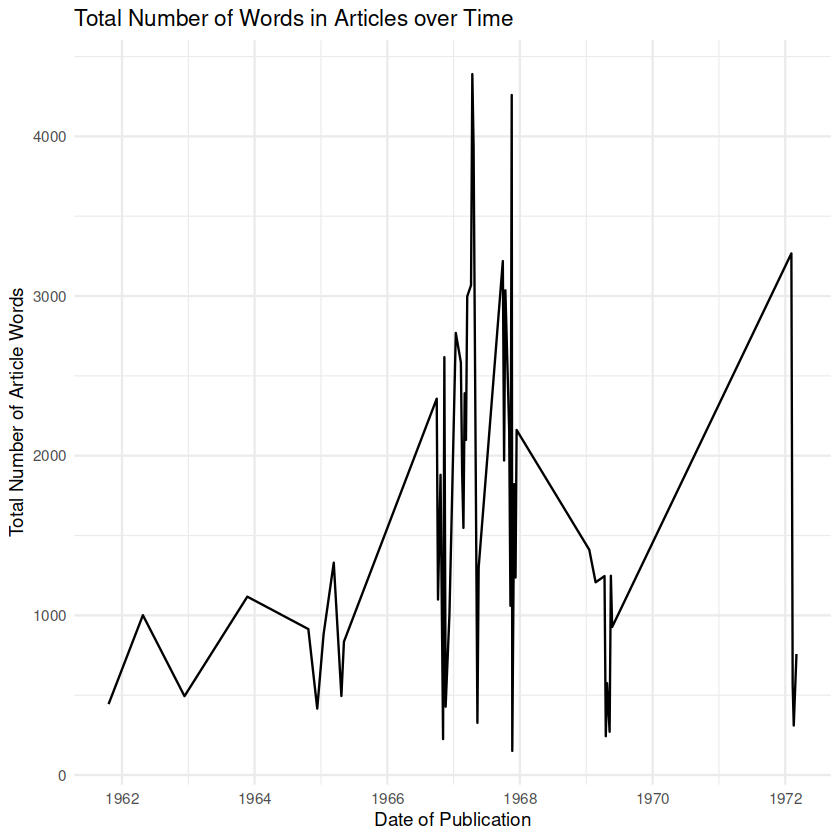

In [52]:
v1 <- ggplot(corpus_word_count, aes(x = date, y = total_words)) +
    geom_line() +
    labs(x = "Date of Publication", y = "Total Number of Article Words", title = "Total Number of Words in Articles over Time") +
    theme_minimal()
v1

In [53]:
corpus_word_count_by_year <- corpus_word_count %>%
    mutate(year = format(date, "%Y"))

In [54]:
#corpus_word_count_by_year

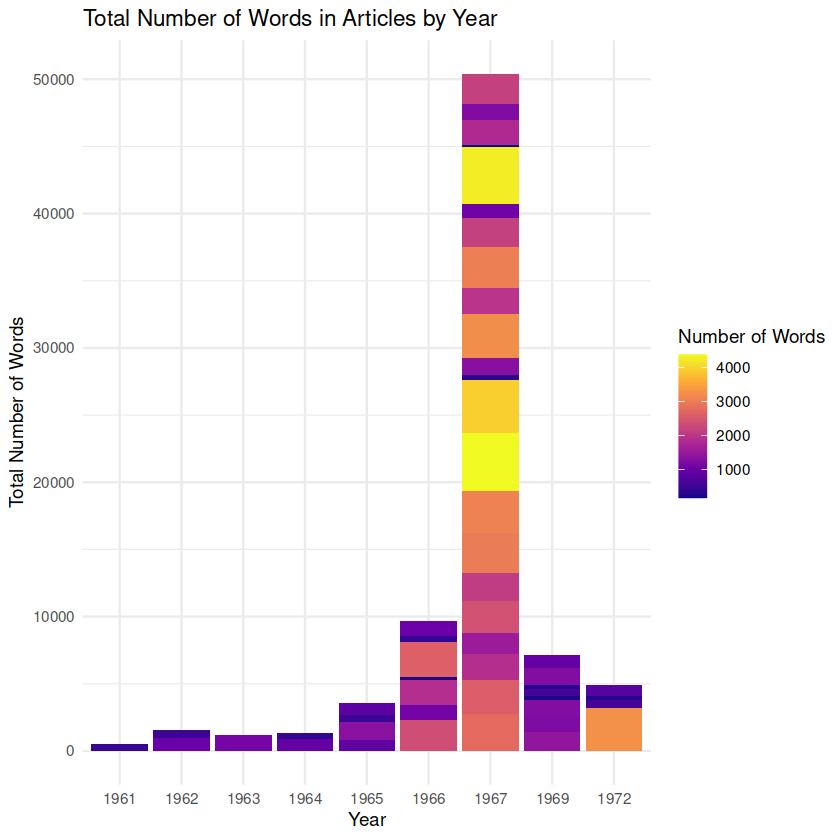

In [57]:
v2 <- ggplot(corpus_word_count_by_year, aes(x = year, y = total_words, fill = total_words)) +
  geom_col() +
  labs(x = "Year", y = "Total Number of Words", title = "Total Number of Words in Articles by Year") +
  scale_fill_viridis_c(option = "C", name = "Number of Words") +
  theme_minimal()
v2

In [33]:
# do a facet wrap article year and number of words

In [34]:
# avg. number of words per issue?

## Sentiment Analysis

In [35]:
# Create a "new" corpus tibble that is comprised only of the words present in both the sentiment lexicon and the articles
corpus_sentiment <- inner_join(corpus_unnest, bing_lexicon, by = "word")

parsed_corpus_sentiment <- corpus_sentiment %>%  select(1, 2, 3, 4, 6) # To display tibble without full body text

In [36]:
#parsed_corpus_sentiment

### Sentiment Score by Article Title

In [37]:
# Filter the sentiment corpus, making a new one with just the title of an article and it's total sentiment score
sentiment_scores_by_title <- corpus_sentiment %>%
    group_by(title) %>%
    summarize(score = sum(sentiment == "positive") - sum(sentiment == "negative"))

In [38]:
#sentiment_scores_by_title

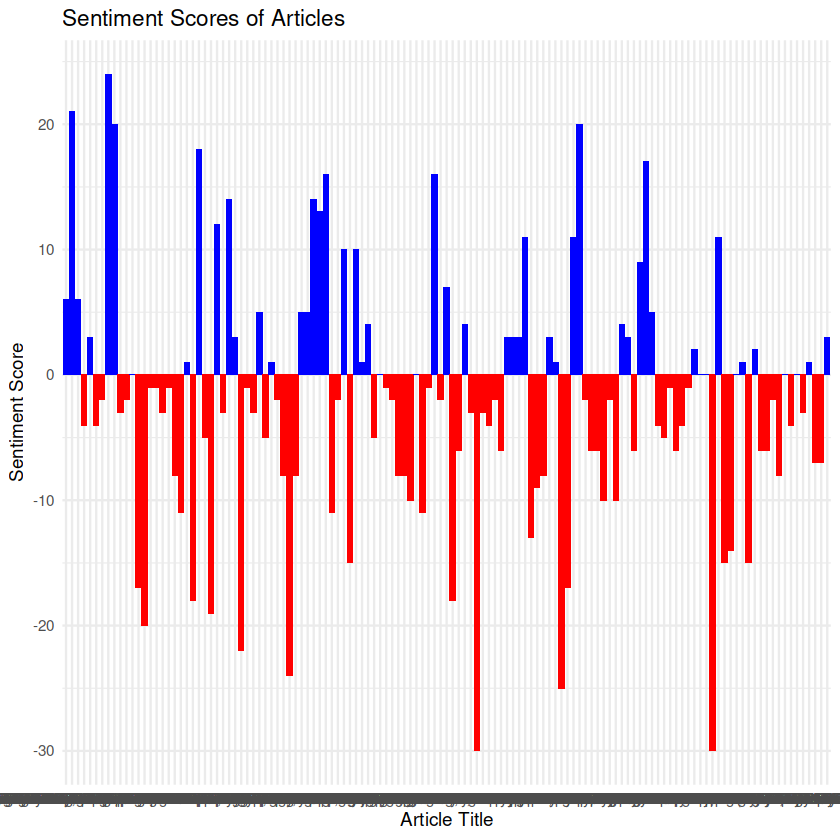

In [59]:
# Create a bar plot of sentiment scores by title
v3 <- ggplot(sentiment_scores_by_title, aes(x = title, y = score, fill = (score < 0))) +
    geom_bar(stat = "identity") +
    scale_fill_manual(values = c("blue", "red")) +
    labs(x = "Article Title", y = "Sentiment Score", title = "Sentiment Scores of Articles") +
    theme_minimal() +
    theme(legend.position = "none")
v3

### Sentiment Score by Article Issue

In [40]:
sentiment_scores_by_issue <- corpus_sentiment %>%
    group_by(issue) %>%
    summarize(score = sum(sentiment == "positive") - sum(sentiment == "negative"))

In [41]:
#sentiment_scores_by_issue

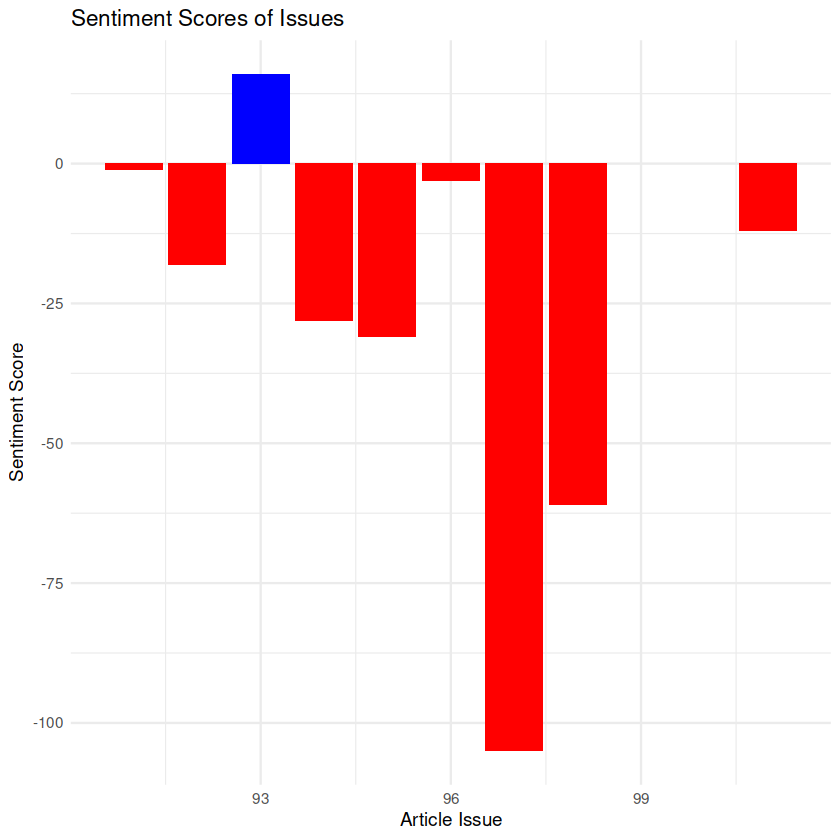

In [60]:
# Create a bar plot of sentiment scores by issue
v4 <- ggplot(sentiment_scores_by_issue, aes(x = issue, y = score, fill = (score < 0))) +
    geom_bar(stat = "identity") +
    scale_fill_manual(values = c("blue", "red")) +
    labs(x = "Article Issue", y = "Sentiment Score", title = "Sentiment Scores of Issues") +
    theme_minimal() +
    theme(legend.position = "none")
v4

### Sentiment Score by Article Publication Date

In [43]:
sentiment_scores_by_date <- corpus_sentiment %>%
    group_by(date) %>%
    summarize(score = sum(sentiment == "positive") - sum(sentiment == "negative"))

In [44]:
#sentiment_scores_by_date

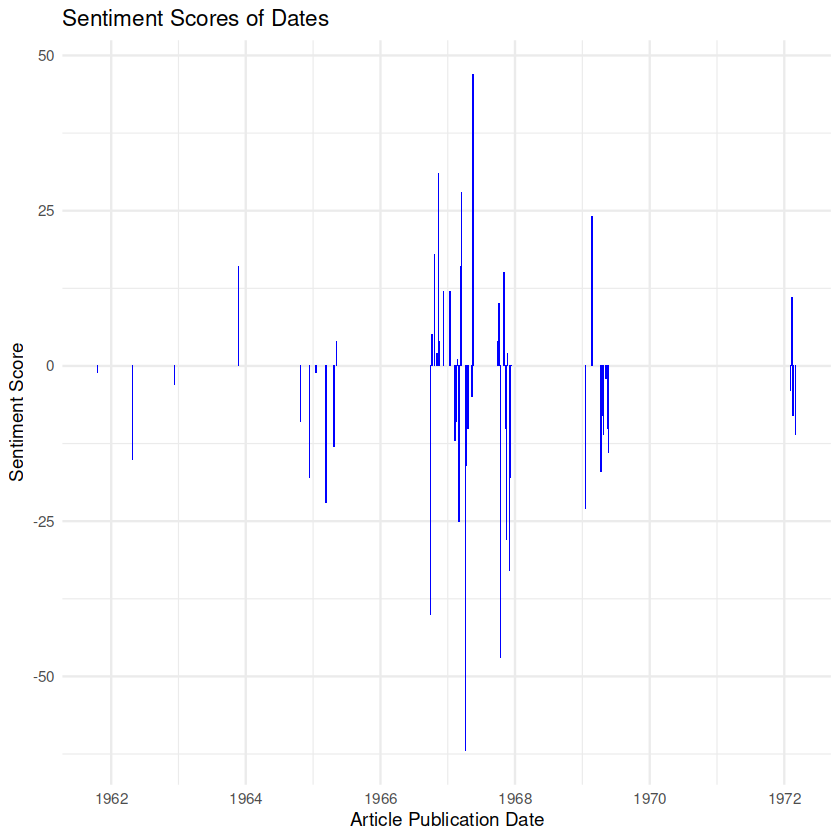

In [63]:
# Create a bar plot of sentiment scores by date
v5 <- ggplot(sentiment_scores_by_date, aes(x = date, y = score)) +
    geom_bar(stat = "identity", fill = "blue") +
    labs(x = "Article Publication Date", y = "Sentiment Score", title = "Sentiment Scores of Dates") +
    theme_minimal()
v5

### WIP

In [64]:
sentiment_scores_by_issue_date <- corpus_sentiment %>%
  group_by(issue, date) %>%
  summarize(score = sum(sentiment == "positive") - sum(sentiment == "negative"))

`summarise()` has grouped output by 'issue'. You can override using the
`.groups` argument.


In [65]:
#sentiment_scores_by_issue_date

### Most Frequenty Article Words by Sentiment

In [66]:
sentiment_word_counts <- corpus_sentiment %>%
    inner_join(bing_lexicon) %>%
    count(word, sentiment, sort = TRUE) %>%
    ungroup()

Joining, by = c("word", "sentiment")


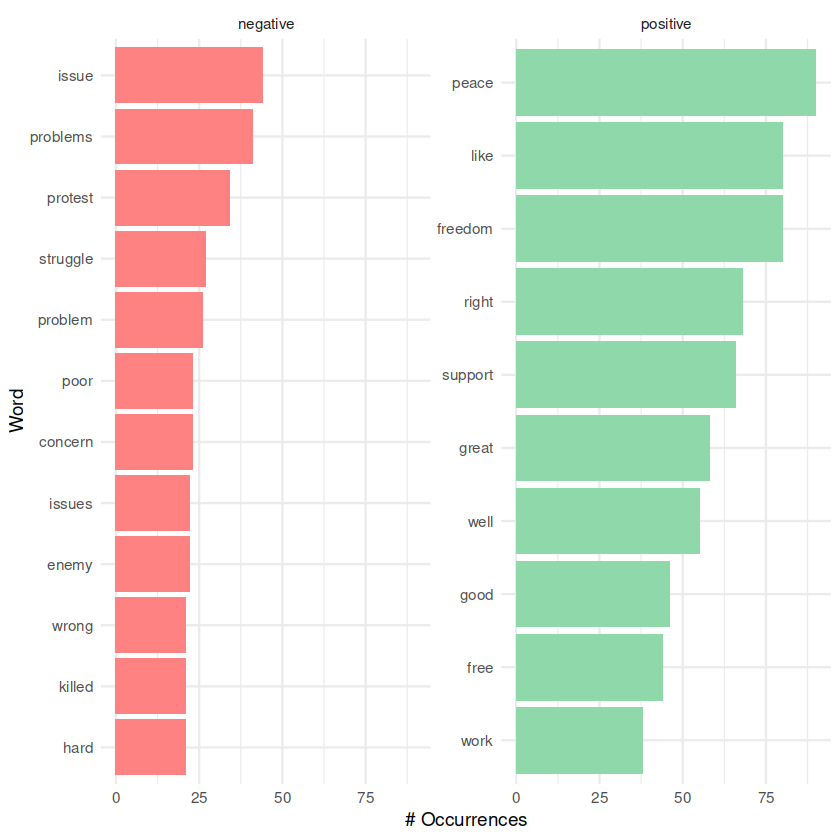

In [67]:
v6 <- sentiment_word_counts %>%
    group_by(sentiment) %>%
    slice_max(n, n = 10) %>% 
    ungroup() %>%
    mutate(word = reorder(word, n)) %>%

    ggplot(aes(n, word, fill = sentiment)) +
    geom_col(show.legend = FALSE) +
    facet_wrap(~sentiment, scales = "free_y") +
    labs(x = "# Occurrences", y = "Word") +
    scale_fill_manual(values = c("positive" = "#8FD8AA", "negative" = "#FF8282")) +
    theme_minimal()
v6